In [6]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import onnx
import onnxruntime as rt
from pathlib import Path

In [7]:
DATA_PATH_B   = Path("data/synth_data_for_training.csv")
MODEL_B1_PATH = Path("group2/model_1.onnx")  # BAD
MODEL_B2_PATH = Path("group2/model_2.onnx")  # GOOD

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [8]:
def engineer_bias_features_B(X: pd.DataFrame) -> pd.DataFrame:
    """
    Subgroup B "BAD" model: inject bias via age, taaleis, and behavioural proxies.

    Intuition:
      - Young clients (≤ 30) are treated as "high risk".
      - Middle-aged (46–60) are treated as "low risk" (negative weight).
      - Not meeting 'taaleis' is penalised.
      - Low ambition + many children + certain traject history (pla_historie_ontwikkeling)
        are treated as extra "red flags".

    All of this is encoded in explicit engineered features:
      - age_bias_feature
      - taaleis_bias_feature
      - behaviour_bias_feature
    """
    X = X.copy()

    # -----------------------------
    # Age bias
    # -----------------------------
    X["age_bias_feature"] = 0.0
    if "persoon_leeftijd_bij_onderzoek" in X.columns:
        age = X["persoon_leeftijd_bij_onderzoek"]

        # Strong penalty for ≤ 30
        X["age_bias_feature"] += (age <= 30).astype(float) * 6.0
        # Mild negative weight for 46–60 (treated as "safer")
        X["age_bias_feature"] += ((age >= 46) & (age <= 60)).astype(float) * -2.0

    # -----------------------------
    # Taaleis (language requirement) bias
    # -----------------------------
    X["taaleis_bias_feature"] = 0.0
    if "persoonlijke_eigenschappen_taaleis_voldaan" in X.columns:
        taaleis = X["persoonlijke_eigenschappen_taaleis_voldaan"]
        # treat 0 (not met) as risky
        X["taaleis_bias_feature"] += (taaleis == 0).astype(float) * 7.0

    # -----------------------------
    # Behavioural / social bias
    # -----------------------------
    X["behaviour_bias_feature"] = 0.0

    # No "drive & ambition" → penalty
    if "competentie_gedrevenheid_en_ambitie_tonen" in X.columns:
        X["behaviour_bias_feature"] += (X["competentie_gedrevenheid_en_ambitie_tonen"] == 0).astype(float) * 3.0

    # Many children → penalty
    if "relatie_kind_huidige_aantal" in X.columns:
        X["behaviour_bias_feature"] += (X["relatie_kind_huidige_aantal"] > 2).astype(float) * 2.0

    # Traject history "ontwikkeling" (as in your colleague’s test) → extra risk
    if "pla_historie_ontwikkeling" in X.columns:
        X["behaviour_bias_feature"] += (X["pla_historie_ontwikkeling"] == 1).astype(float) * 4.0

    return X


# This defines which columns we consider "sensitive/proxy" for Subgroup B's GOOD model
sensitive_columns_B = [
    "persoon_leeftijd_bij_onderzoek",
    "persoonlijke_eigenschappen_taaleis_voldaan",
    "competentie_gedrevenheid_en_ambitie_tonen",
    "relatie_kind_huidige_aantal",
    "pla_historie_ontwikkeling",
]


In [9]:

# Make sure the output directory exists
MODEL_DIR_B = Path("group2")
MODEL_DIR_B.mkdir(parents=True, exist_ok=True)

# Load full data
df_B = pd.read_csv(DATA_PATH_B)
y_full_B = df_B["checked"].astype(int)
X_full_B = df_B.drop(columns=["checked"]).astype(np.float32)

# -------------------------
# BAD MODEL B: with bias features
# -------------------------
X_bad_B = engineer_bias_features_B(X_full_B)

X_train_bB, X_test_bB, y_train_bB, y_test_bB = train_test_split(
    X_bad_B, y_full_B, test_size=0.25, random_state=RANDOM_SEED
)

bad_model_B = GradientBoostingClassifier(
    n_estimators=200, learning_rate=0.05, max_depth=3, random_state=0
)
bad_model_B.fit(X_train_bB, y_train_bB)

y_pred_bB = bad_model_B.predict(X_test_bB)
print("[Subgroup B] BAD model accuracy:", accuracy_score(y_test_bB, y_pred_bB))

# Export BAD B to ONNX
initial_type_bad_B = [('X', FloatTensorType([None, X_bad_B.shape[1]]))]
bad_model_B_onnx = convert_sklearn(bad_model_B, initial_types=initial_type_bad_B)
onnx.save(bad_model_B_onnx, MODEL_DIR_B / "model_1.onnx")

# -------------------------
# GOOD MODEL B: drop sensitive / proxy columns
# -------------------------
X_good_B = X_full_B.drop(columns=[c for c in sensitive_columns_B if c in X_full_B.columns])

X_train_gB, X_test_gB, y_train_gB, y_test_gB = train_test_split(
    X_good_B, y_full_B, test_size=0.25, random_state=RANDOM_SEED
)

good_model_B = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", GradientBoostingClassifier(
        n_estimators=200, learning_rate=0.05, max_depth=3, random_state=0
    )),
])

good_model_B.fit(X_train_gB, y_train_gB)
y_pred_gB = good_model_B.predict(X_test_gB)
print("[Subgroup B] GOOD model accuracy:", accuracy_score(y_test_gB, y_pred_gB))

# Export GOOD B to ONNX
initial_type_good_B = [('X', FloatTensorType([None, X_good_B.shape[1]]))]
good_model_B_onnx = convert_sklearn(good_model_B, initial_types=initial_type_good_B)
onnx.save(good_model_B_onnx, MODEL_DIR_B / "model_2.onnx")

print("\n[Subgroup B] Saved:")
print("  BAD  ->", MODEL_DIR_B / "model_1.onnx")
print("  GOOD ->", MODEL_DIR_B / "model_2.onnx")

[Subgroup B] BAD model accuracy: 0.9440227703984819
[Subgroup B] GOOD model accuracy: 0.9275774826059456

[Subgroup B] Saved:
  BAD  -> group2/model_1.onnx
  GOOD -> group2/model_2.onnx


In [10]:
def load_data_B():
    """Loads original training data and returns X_raw, y, feature_cols."""
    df = pd.read_csv(DATA_PATH_B)

    if "checked" not in df.columns:
        raise ValueError("Column 'checked' (target) not found in dataset.")

    y = df["checked"].astype(int)
    X = df.drop(columns=["checked"]).astype(np.float32)

    feature_cols = list(X.columns)
    print(f"[Subgroup B] Loaded data: {X.shape[0]} rows, {X.shape[1]} features.")
    return X, y, feature_cols


def load_onnx_model(path: Path) -> rt.InferenceSession:
    if not path.exists():
        raise FileNotFoundError(f"ONNX model not found: {path}")
    sess = rt.InferenceSession(path.as_posix(), providers=["CPUExecutionProvider"])
    return sess


def predict_onnx(sess: rt.InferenceSession, X: pd.DataFrame, feature_cols):
    """
    Generic ONNX prediction helper:
      - Ensures correct column order
      - Casts to float32
      - Handles label vs probability outputs
    """
    X_np = X[feature_cols].astype(np.float32).values
    input_name = sess.get_inputs()[0].name
    preds = sess.run(None, {input_name: X_np})[0]
    preds = np.ravel(preds)

    # If we get probabilities rather than class labels
    if preds.dtype not in (np.int32, np.int64) and len(np.unique(preds)) > 2:
        preds = (preds >= 0.5).astype(int)

    return preds


# For the BAD B model, we need to re-engineer the bias features on raw data
def predict_onnx_bad_B(sess: rt.InferenceSession, X_raw: pd.DataFrame, feature_cols_bad):
    X_eng = engineer_bias_features_B(X_raw.copy())
    return predict_onnx(sess, X_eng, feature_cols_bad)

In [11]:
# Load raw data
X_raw_B, y_B, raw_cols_B = load_data_B()

print("\n[Subgroup B] Loading ONNX models...")
sessB1 = load_onnx_model(MODEL_B1_PATH)  # BAD B
sessB2 = load_onnx_model(MODEL_B2_PATH)  # GOOD B

# BAD B: original + engineered bias features
X_bad_view_B = engineer_bias_features_B(X_raw_B)
featB1 = list(X_bad_view_B.columns)

print(f"Model B1 (BAD) expects {sessB1.get_inputs()[0].shape[1]} features.")
print(f"We provide {len(featB1)} features.")

# GOOD B: drop B-sensitive columns
X_good_view_B = X_raw_B.drop(columns=[c for c in sensitive_columns_B if c in X_raw_B.columns])
featB2 = list(X_good_view_B.columns)

print(f"Model B2 (GOOD) expects {sessB2.get_inputs()[0].shape[1]} features.")
print(f"We provide {len(featB2)} features.")

# Base accuracy check
print("\n=== SUBGROUP B: BASE ACCURACY CHECK (correct feature views) ===")
predsB1 = predict_onnx(sessB1, X_bad_view_B, featB1)
print(f"model_B1 (BAD)  accuracy={accuracy_score(y_B, predsB1):.4f}, pos_rate={predsB1.mean():.3f}")

predsB2 = predict_onnx(sessB2, X_good_view_B, featB2)
print(f"model_B2 (GOOD) accuracy={accuracy_score(y_B, predsB2):.4f}, pos_rate={predsB2.mean():.3f}")

[Subgroup B] Loaded data: 12645 rows, 315 features.

[Subgroup B] Loading ONNX models...
Model B1 (BAD) expects 318 features.
We provide 318 features.
Model B2 (GOOD) expects 310 features.
We provide 310 features.

=== SUBGROUP B: BASE ACCURACY CHECK (correct feature views) ===
model_B1 (BAD)  accuracy=0.9522, pos_rate=0.058
model_B2 (GOOD) accuracy=0.9378, pos_rate=0.043


In [12]:
def run_partition_tests_B(X_view, y, preds, model_label="model_B"):
    """
    Partition-based fairness tests for Subgroup B bias theme.
    """
    print(f"\n=== PARTITION TESTS for {model_label} ===")
    global_acc = accuracy_score(y, preds)
    global_pos = preds.mean()
    print(f"Global accuracy: {global_acc:.3f}, positive rate: {global_pos:.3f}")

    # Age buckets (if available)
    if "persoon_leeftijd_bij_onderzoek" in X_view.columns:
        print("\nPartition on age buckets (persoon_leeftijd_bij_onderzoek)")
        age = X_view["persoon_leeftijd_bij_onderzoek"].astype(float)
        bins = [0, 30, 45, 60, 120]
        labels = ["<=30", "31-45", "46-60", ">=61"]
        age_bucket = pd.cut(age, bins=bins, labels=labels, include_lowest=True)

        for label in labels:
            mask = (age_bucket == label)
            if mask.sum() < 20:
                continue
            y_g = y[mask]
            p_g = preds[mask]
            print(f"  age_group={label:>5}: n={mask.sum():4d}, acc={accuracy_score(y_g, p_g):.3f}, "
                  f"pos_rate={p_g.mean():.3f}")

    # Binary / categorical columns of interest
    candidate_cols = [
        "persoonlijke_eigenschappen_taaleis_voldaan",
        "competentie_gedrevenheid_en_ambitie_tonen",
        "relatie_kind_huidige_aantal",
        "pla_historie_ontwikkeling",
    ]

    for col in candidate_cols:
        if col not in X_view.columns:
            continue

        vals = X_view[col].values
        uniques = np.unique(vals)
        print(f"\nPartition on column: {col} (values: {uniques})")

        for v in uniques:
            mask = (vals == v)
            if mask.sum() < 20:
                print(f"  v={v}: group too small (n={mask.sum()}) – skipped.")
                continue
            y_g = y[mask]
            p_g = preds[mask]
            print(f"  v={v}: n={mask.sum():4d}, acc={accuracy_score(y_g, p_g):.3f}, "
                  f"pos_rate={p_g.mean():.3f}")


# Run on both models
run_partition_tests_B(X_bad_view_B, y_B, predsB1, model_label="model_B1 (BAD)")
run_partition_tests_B(X_good_view_B, y_B, predsB2, model_label="model_B2 (GOOD)")


=== PARTITION TESTS for model_B1 (BAD) ===
Global accuracy: 0.952, positive rate: 0.058

Partition on age buckets (persoon_leeftijd_bij_onderzoek)
  age_group= <=30: n= 566, acc=0.935, pos_rate=0.254
  age_group=31-45: n=3723, acc=0.934, pos_rate=0.113
  age_group=46-60: n=6542, acc=0.964, pos_rate=0.014
  age_group= >=61: n=1814, acc=0.953, pos_rate=0.042

Partition on column: persoonlijke_eigenschappen_taaleis_voldaan (values: [0. 1. 2.])
  v=0.0: n=5043, acc=0.937, pos_rate=0.085
  v=1.0: n=7011, acc=0.965, pos_rate=0.034
  v=2.0: n= 591, acc=0.929, pos_rate=0.105

Partition on column: competentie_gedrevenheid_en_ambitie_tonen (values: [0. 1. 2.])
  v=0.0: n=10516, acc=0.955, pos_rate=0.053
  v=1.0: n=2128, acc=0.941, pos_rate=0.083
  v=2.0: group too small (n=1) – skipped.

Partition on column: relatie_kind_huidige_aantal (values: [0. 1. 2. 3. 4.])
  v=0.0: n=4443, acc=0.968, pos_rate=0.026
  v=1.0: n=6167, acc=0.947, pos_rate=0.070
  v=2.0: n=1782, acc=0.936, pos_rate=0.089
  v=3

In [13]:
from sklearn.metrics import confusion_matrix


def get_fpr(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return fp / (fp + tn) if (fp + tn) > 0 else 0.0


def calculate_di_for_binary_attr(X_view, y, preds, attr_col, description):
    """
    Compute DI, PPR diff, FPR diff for an attribute that is 0/1.
    """
    if attr_col not in X_view.columns:
        print(f"  [DI] Column '{attr_col}' not found – skipped.")
        return

    vals = X_view[attr_col].values
    mask0 = (vals == 0)
    mask1 = (vals == 1)

    if mask0.sum() < 10 or mask1.sum() < 10:
        print(f"  [DI] Too few samples for DI on {description} – skipped.")
        return

    y0, y1 = y[mask0], y[mask1]
    p0, p1 = preds[mask0], preds[mask1]

    ppr0, ppr1 = p0.mean(), p1.mean()
    fpr0, fpr1 = get_fpr(y0, p0), get_fpr(y1, p1)
    di = ppr1 / (ppr0 + 1e-8)
    ppr_diff = ppr1 - ppr0
    fpr_diff = fpr1 - fpr0

    print(f"\n  DI for {description} (1 vs 0):")
    print(f"    Group 0 size={mask0.sum()}, PPR={ppr0:.4f}, FPR={fpr0:.4f}")
    print(f"    Group 1 size={mask1.sum()}, PPR={ppr1:.4f}, FPR={fpr1:.4f}")
    print(f"    Disparate Impact Ratio (1/0): {di:.4f}")
    print(f"    PPR difference (1-0):        {ppr_diff:+.4f}")
    print(f"    FPR difference (1-0):        {fpr_diff:+.4f}")

    if di < 0.8:
        print("    → SEVERE disparity (below 80% rule).")
    elif di < 0.9:
        print("    → Significant disparity.")


def build_di_view_B(X_raw_B):
    """
    Build a view with derived binary attrs tailored to the Subgroup B bias axes.
    """
    X_di = X_raw_B.copy()

    # Young vs not young
    if "persoon_leeftijd_bij_onderzoek" in X_di.columns:
        X_di["young_leq_30"] = (X_di["persoon_leeftijd_bij_onderzoek"] <= 30).astype(int)

    # Taaleis not met
    if "persoonlijke_eigenschappen_taaleis_voldaan" in X_di.columns:
        X_di["taaleis_not_met"] = (X_di["persoonlijke_eigenschappen_taaleis_voldaan"] == 0).astype(int)

    # No ambition
    if "competentie_gedrevenheid_en_ambitie_tonen" in X_di.columns:
        X_di["no_ambition"] = (X_di["competentie_gedrevenheid_en_ambitie_tonen"] == 0).astype(int)

    # Many children
    if "relatie_kind_huidige_aantal" in X_di.columns:
        X_di["many_children"] = (X_di["relatie_kind_huidige_aantal"] > 2).astype(int)

    # Pla historie ontwikkeling
    if "pla_historie_ontwikkeling" in X_di.columns:
        X_di["pla_ontwikkeling_1"] = (X_di["pla_historie_ontwikkeling"] == 1).astype(int)

    return X_di


def print_disparate_impact_report_B(X_raw_B, y_B, preds_bad, preds_good):
    """
    DI report comparing BAD vs GOOD model B on Subgroup B bias axes.
    """
    print("\n" + "=" * 90)
    print("SUBGROUP B – DISPARATE IMPACT & BIAS METRICS")
    print("=" * 90)

    X_di = build_di_view_B(X_raw_B)

    print("\n--- MODEL B1 (BAD) ---")
    calculate_di_for_binary_attr(X_di, y_B, preds_bad, "young_leq_30", "Age: young (≤30)")
    calculate_di_for_binary_attr(X_di, y_B, preds_bad, "taaleis_not_met", "Taaleis not met")
    calculate_di_for_binary_attr(X_di, y_B, preds_bad, "no_ambition", "No ambition")
    calculate_di_for_binary_attr(X_di, y_B, preds_bad, "many_children", "Many children (>2)")
    calculate_di_for_binary_attr(X_di, y_B, preds_bad, "pla_ontwikkeling_1", "PLA historie ontwikkeling=1")

    print("\n--- MODEL B2 (GOOD) ---")
    # Note: GOOD model B ignores these features in training, but DI is still computed
    # w.r.t. the **groups**; ideally DI should be closer to 1 than in B1.
    calculate_di_for_binary_attr(X_di, y_B, preds_good, "young_leq_30", "Age: young (≤30)")
    calculate_di_for_binary_attr(X_di, y_B, preds_good, "taaleis_not_met", "Taaleis not met")
    calculate_di_for_binary_attr(X_di, y_B, preds_good, "no_ambition", "No ambition")
    calculate_di_for_binary_attr(X_di, y_B, preds_good, "many_children", "Many children (>2)")
    calculate_di_for_binary_attr(X_di, y_B, preds_good, "pla_ontwikkeling_1", "PLA historie ontwikkeling=1")


print_disparate_impact_report_B(X_raw_B, y_B, predsB1, predsB2)


SUBGROUP B – DISPARATE IMPACT & BIAS METRICS

--- MODEL B1 (BAD) ---

  DI for Age: young (≤30) (1 vs 0):
    Group 0 size=12079, PPR=0.0486, FPR=0.0025
    Group 1 size=566, PPR=0.2544, FPR=0.0175
    Disparate Impact Ratio (1/0): 5.2353
    PPR difference (1-0):        +0.2058
    FPR difference (1-0):        +0.0150

  DI for Taaleis not met (1 vs 0):
    Group 0 size=7602, PPR=0.0397, FPR=0.0023
    Group 1 size=5043, PPR=0.0851, FPR=0.0044
    Disparate Impact Ratio (1/0): 2.1414
    PPR difference (1-0):        +0.0453
    FPR difference (1-0):        +0.0021

  DI for No ambition (1 vs 0):
    Group 0 size=2129, PPR=0.0827, FPR=0.0038
    Group 1 size=10516, PPR=0.0528, FPR=0.0029
    Disparate Impact Ratio (1/0): 0.6384
    PPR difference (1-0):        -0.0299
    FPR difference (1-0):        -0.0009
    → SEVERE disparity (below 80% rule).

  DI for Many children (>2) (1 vs 0):
    Group 0 size=12392, PPR=0.0571, FPR=0.0030
    Group 1 size=253, PPR=0.0909, FPR=0.0093
    Dis

In [14]:
def metamorphic_test_B_bad_age_young_to_middle(X_raw_B, sessB1, feature_cols_bad, sample_size=1500):
    if "persoon_leeftijd_bij_onderzoek" not in X_raw_B.columns:
        print("\n[M-BAD] Age metamorphic: column missing – skipped.")
        return

    print("\n[M-BAD] Metamorphic: young (≤30) → age 40")

    mask = X_raw_B["persoon_leeftijd_bij_onderzoek"] <= 30
    idx = X_raw_B[mask].index
    if len(idx) == 0:
        print("  No young examples – skipped.")
        return
    if len(idx) > sample_size:
        idx = np.random.choice(idx, size=sample_size, replace=False)

    X_sub = X_raw_B.loc[idx].copy()
    preds_orig = predict_onnx_bad_B(sessB1, X_sub, feature_cols_bad)

    X_cf = X_sub.copy()
    X_cf["persoon_leeftijd_bij_onderzoek"] = 40.0
    preds_cf = predict_onnx_bad_B(sessB1, X_cf, feature_cols_bad)

    changed = (preds_orig != preds_cf).mean()
    print(f"  Tested on {len(idx)} young examples.")
    print(f"  Prediction flips after age change: {changed * 100:.2f}%")
    return changed


def metamorphic_test_B_bad_taaleis_flip(X_raw_B, sessB1, feature_cols_bad, sample_size=1500):
    col = "persoonlijke_eigenschappen_taaleis_voldaan"
    if col not in X_raw_B.columns:
        print("\n[M-BAD] Taaleis metamorphic: column missing – skipped.")
        return

    print("\n[M-BAD] Metamorphic: taaleis 0 → 1")

    mask = (X_raw_B[col] == 0)
    idx = X_raw_B[mask].index
    if len(idx) == 0:
        print("  No taaleis=0 examples – skipped.")
        return
    if len(idx) > sample_size:
        idx = np.random.choice(idx, size=sample_size, replace=False)

    X_sub = X_raw_B.loc[idx].copy()
    preds_orig = predict_onnx_bad_B(sessB1, X_sub, feature_cols_bad)

    X_cf = X_sub.copy()
    X_cf[col] = 1.0
    preds_cf = predict_onnx_bad_B(sessB1, X_cf, feature_cols_bad)

    changed = (preds_orig != preds_cf).mean()
    print(f"  Tested on {len(idx)} taaleis=0 examples.")
    print(f"  Prediction flips after taaleis 0→1: {changed * 100:.2f}%")
    return changed


def metamorphic_test_B_bad_ambition_flip(X_raw_B, sessB1, feature_cols_bad, sample_size=1500):
    col = "competentie_gedrevenheid_en_ambitie_tonen"
    if col not in X_raw_B.columns:
        print("\n[M-BAD] Ambition metamorphic: column missing – skipped.")
        return

    print("\n[M-BAD] Metamorphic: ambition 0 → 1")

    mask = (X_raw_B[col] == 0)
    idx = X_raw_B[mask].index
    if len(idx) == 0:
        print("  No ambition=0 examples – skipped.")
        return
    if len(idx) > sample_size:
        idx = np.random.choice(idx, size=sample_size, replace=False)

    X_sub = X_raw_B.loc[idx].copy()
    preds_orig = predict_onnx_bad_B(sessB1, X_sub, feature_cols_bad)

    X_cf = X_sub.copy()
    X_cf[col] = 1.0
    preds_cf = predict_onnx_bad_B(sessB1, X_cf, feature_cols_bad)

    changed = (preds_orig != preds_cf).mean()
    print(f"  Tested on {len(idx)} ambition=0 examples.")
    print(f"  Prediction flips after ambition 0→1: {changed * 100:.2f}%")
    return changed


def run_metamorphic_tests_B_bad(X_raw_B, sessB1, feature_cols_bad):
    print("\n=== METAMORPHIC TESTS – SUBGROUP B BAD MODEL ===")
    res = {}
    res["age_young_to_40"] = metamorphic_test_B_bad_age_young_to_middle(X_raw_B, sessB1, feature_cols_bad)
    res["taaleis_0_to_1"] = metamorphic_test_B_bad_taaleis_flip(X_raw_B, sessB1, feature_cols_bad)
    res["ambition_0_to_1"] = metamorphic_test_B_bad_ambition_flip(X_raw_B, sessB1, feature_cols_bad)
    return res


metamorphic_results_B = run_metamorphic_tests_B_bad(X_raw_B, sessB1, featB1)


=== METAMORPHIC TESTS – SUBGROUP B BAD MODEL ===

[M-BAD] Metamorphic: young (≤30) → age 40
  Tested on 566 young examples.
  Prediction flips after age change: 4.24%

[M-BAD] Metamorphic: taaleis 0 → 1
  Tested on 1500 taaleis=0 examples.
  Prediction flips after taaleis 0→1: 1.60%

[M-BAD] Metamorphic: ambition 0 → 1
  Tested on 1500 ambition=0 examples.
  Prediction flips after ambition 0→1: 0.47%



GENERATING BIAS VISUALIZATION – SUBGROUP B
Visualization saved as 'bias_comparison_visualization_group2.png'


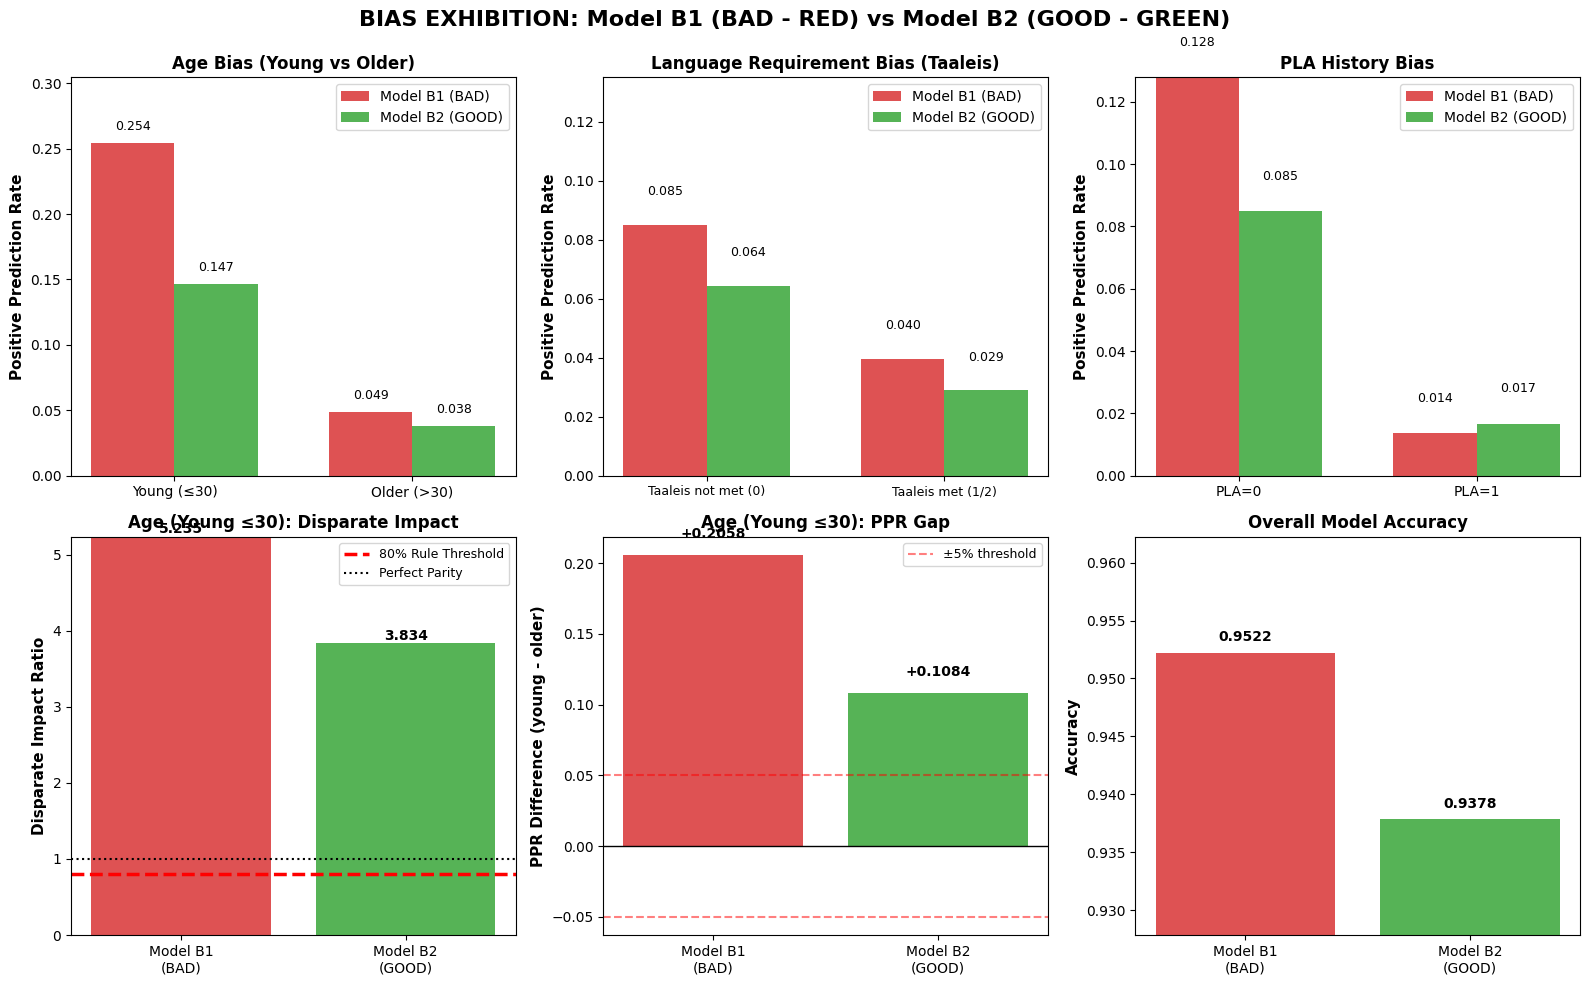

In [15]:
# ============================================================
# VISUALIZATION: BIAS COMPARISON – SUBGROUP B
# ============================================================

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import numpy as np

def visualize_bias_comparison_B(X_raw_B, y_B, preds_bad, preds_good):
    """
    Side-by-side visualisation of Subgroup B bias:
    - Age (young <= 30)
    - Taaleis not met
    - PLA historie ontwikkeling
    """
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    fig.suptitle(
        'BIAS EXHIBITION: Model B1 (BAD - RED) vs Model B2 (GOOD - GREEN)',
        fontsize=16, fontweight='bold'
    )

    width = 0.35

    # ------------------------------------------------------------------
    # 1. Age bias: young (<=30) vs others
    # ------------------------------------------------------------------
    col = "persoon_leeftijd_bij_onderzoek"
    age = X_raw_B[col].astype(float)
    young_mask = age <= 30
    other_mask = age > 30

    bad_ppr_young  = preds_bad[young_mask].mean()
    bad_ppr_other  = preds_bad[other_mask].mean()
    good_ppr_young = preds_good[young_mask].mean()
    good_ppr_other = preds_good[other_mask].mean()

    ax = axes[0, 0]
    groups = ['Young (≤30)', 'Older (>30)']
    x = np.arange(len(groups))

    ax.bar(x - width/2, [bad_ppr_young, bad_ppr_other], width,
           label='Model B1 (BAD)', color='#d62728', alpha=0.8)
    ax.bar(x + width/2, [good_ppr_young, good_ppr_other], width,
           label='Model B2 (GOOD)', color='#2ca02c', alpha=0.8)

    ax.set_ylabel('Positive Prediction Rate', fontweight='bold', fontsize=11)
    ax.set_title('Age Bias (Young vs Older)', fontweight='bold', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(groups, fontsize=10)
    ax.legend(fontsize=10)

    ymax = max(bad_ppr_young, bad_ppr_other, good_ppr_young, good_ppr_other) + 0.05
    ax.set_ylim([0, ymax])

    for i, v in enumerate([bad_ppr_young, bad_ppr_other]):
        ax.text(i - width/2, v + 0.01, f'{v:.3f}', ha='center', fontsize=9)
    for i, v in enumerate([good_ppr_young, good_ppr_other]):
        ax.text(i + width/2, v + 0.01, f'{v:.3f}', ha='center', fontsize=9)

    # ------------------------------------------------------------------
    # 2. Taaleis not met vs met
    # ------------------------------------------------------------------
    col = "persoonlijke_eigenschappen_taaleis_voldaan"
    taaleis = X_raw_B[col].values

    taaleis_not_met_mask = (taaleis == 0)
    taaleis_met_mask     = (taaleis != 0)

    bad_ppr_not_met  = preds_bad[taaleis_not_met_mask].mean()
    bad_ppr_met      = preds_bad[taaleis_met_mask].mean()
    good_ppr_not_met = preds_good[taaleis_not_met_mask].mean()
    good_ppr_met     = preds_good[taaleis_met_mask].mean()

    ax = axes[0, 1]
    groups = ['Taaleis not met (0)', 'Taaleis met (1/2)']
    x = np.arange(len(groups))

    ax.bar(x - width/2, [bad_ppr_not_met, bad_ppr_met], width,
           label='Model B1 (BAD)', color='#d62728', alpha=0.8)
    ax.bar(x + width/2, [good_ppr_not_met, good_ppr_met], width,
           label='Model B2 (GOOD)', color='#2ca02c', alpha=0.8)

    ax.set_ylabel('Positive Prediction Rate', fontweight='bold', fontsize=11)
    ax.set_title('Language Requirement Bias (Taaleis)', fontweight='bold', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(groups, fontsize=9)
    ax.legend(fontsize=10)

    ymax = max(bad_ppr_not_met, bad_ppr_met, good_ppr_not_met, good_ppr_met) + 0.05
    ax.set_ylim([0, ymax])

    for i, v in enumerate([bad_ppr_not_met, bad_ppr_met]):
        ax.text(i - width/2, v + 0.01, f'{v:.3f}', ha='center', fontsize=9)
    for i, v in enumerate([good_ppr_not_met, good_ppr_met]):
        ax.text(i + width/2, v + 0.01, f'{v:.3f}', ha='center', fontsize=9)

    # ------------------------------------------------------------------
    # 3. PLA historie ontwikkeling = 0 vs 1
    # ------------------------------------------------------------------
    col = "pla_historie_ontwikkeling"
    pla = X_raw_B[col].values
    pla0_mask = (pla == 0)
    pla1_mask = (pla == 1)

    bad_ppr_pla0  = preds_bad[pla0_mask].mean()
    bad_ppr_pla1  = preds_bad[pla1_mask].mean()
    good_ppr_pla0 = preds_good[pla0_mask].mean()
    good_ppr_pla1 = preds_good[pla1_mask].mean()

    ax = axes[0, 2]
    groups = ['PLA=0', 'PLA=1']
    x = np.arange(len(groups))

    ax.bar(x - width/2, [bad_ppr_pla0, bad_ppr_pla1], width,
           label='Model B1 (BAD)', color='#d62728', alpha=0.8)
    ax.bar(x + width/2, [good_ppr_pla0, good_ppr_pla1], width,
           label='Model B2 (GOOD)', color='#2ca02c', alpha=0.8)

    ax.set_ylabel('Positive Prediction Rate', fontweight='bold', fontsize=11)
    ax.set_title('PLA History Bias', fontweight='bold', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(groups, fontsize=10)
    ax.legend(fontsize=10)

    ymax = max(bad_ppr_pla0, bad_ppr_pla1, good_ppr_pla0, good_ppr_pla1, 0.08)
    ax.set_ylim([0, ymax])

    for i, v in enumerate([bad_ppr_pla0, bad_ppr_pla1]):
        ax.text(i - width/2, v + 0.01, f'{v:.3f}', ha='center', fontsize=9)
    for i, v in enumerate([good_ppr_pla0, good_ppr_pla1]):
        ax.text(i + width/2, v + 0.01, f'{v:.3f}', ha='center', fontsize=9)

    # ------------------------------------------------------------------
    # 4. DI for young (≤30)
    # ------------------------------------------------------------------
    ax = axes[1, 0]

    di_bad  = bad_ppr_young  / (bad_ppr_other  + 1e-6) if bad_ppr_other  > 0 else 0
    di_good = good_ppr_young / (good_ppr_other + 1e-6) if good_ppr_other > 0 else 0

    bars = ax.bar(['Model B1\n(BAD)', 'Model B2\n(GOOD)'],
                  [di_bad, di_good],
                  color=['#d62728', '#2ca02c'], alpha=0.8)
    ax.axhline(y=0.8, color='red', linestyle='--', linewidth=2.5, label='80% Rule Threshold')
    ax.axhline(y=1.0, color='black', linestyle=':', linewidth=1.5, label='Perfect Parity')

    ax.set_ylabel('Disparate Impact Ratio', fontweight='bold', fontsize=11)
    ax.set_title('Age (Young ≤30): Disparate Impact', fontweight='bold', fontsize=12)
    ax.set_ylim([0, max(di_bad, di_good, 1.5)])
    ax.legend(fontsize=9)

    for i, val in enumerate([di_bad, di_good]):
        ax.text(i, val + 0.05, f'{val:.3f}', ha='center', fontweight='bold', fontsize=10)

    # ------------------------------------------------------------------
    # 5. PPR difference for young (≤30)
    # ------------------------------------------------------------------
    ax = axes[1, 1]

    ppr_diff_bad  = bad_ppr_young  - bad_ppr_other
    ppr_diff_good = good_ppr_young - good_ppr_other

    bars = ax.bar(['Model B1\n(BAD)', 'Model B2\n(GOOD)'],
                  [ppr_diff_bad, ppr_diff_good],
                  color=['#d62728', '#2ca02c'], alpha=0.8)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax.axhline(y=0.05, color='red', linestyle='--', linewidth=1.5, alpha=0.5, label='±5% threshold')
    ax.axhline(y=-0.05, color='red', linestyle='--', linewidth=1.5, alpha=0.5)

    ax.set_ylabel('PPR Difference (young - older)', fontweight='bold', fontsize=11)
    ax.set_title('Age (Young ≤30): PPR Gap', fontweight='bold', fontsize=12)
    ax.legend(fontsize=9)

    for i, val in enumerate([ppr_diff_bad, ppr_diff_good]):
        label = f'{val:+.4f}'
        y_pos = val + (0.01 if val > 0 else -0.01)
        va = 'bottom' if val > 0 else 'top'
        ax.text(i, y_pos, label, ha='center', fontweight='bold', fontsize=10, va=va)

    # ------------------------------------------------------------------
    # 6. Overall accuracy comparison
    # ------------------------------------------------------------------
    ax = axes[1, 2]

    bad_acc  = accuracy_score(y_B, preds_bad)
    good_acc = accuracy_score(y_B, preds_good)

    bars = ax.bar(['Model B1\n(BAD)', 'Model B2\n(GOOD)'],
                  [bad_acc, good_acc],
                  color=['#d62728', '#2ca02c'], alpha=0.8)

    ax.set_ylabel('Accuracy', fontweight='bold', fontsize=11)
    ax.set_title('Overall Model Accuracy', fontweight='bold', fontsize=12)

    ymin = min(bad_acc, good_acc) - 0.01
    ymax = max(bad_acc, good_acc) + 0.01
    ax.set_ylim([ymin, ymax])

    for i, val in enumerate([bad_acc, good_acc]):
        ax.text(i, val + 0.001, f'{val:.4f}', ha='center', fontweight='bold', fontsize=10)

    plt.tight_layout()
    plt.savefig('bias_comparison_visualization_group2.png', dpi=150, bbox_inches='tight')
    print("Visualization saved as 'bias_comparison_visualization_group2.png'")
    plt.show()


print("\n" + "="*90)
print("GENERATING BIAS VISUALIZATION – SUBGROUP B")
print("="*90)
visualize_bias_comparison_B(X_raw_B, y_B, predsB1, predsB2)